$$f(x,y)=\frac{1}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}$$

Покомпонентные плотности распределения:
$$f(x)=\frac{1}{\pi^2 + x^2}$$
$$f(y)=\frac{1}{\pi^2 + (y-1)^2}$$

Совместные плотности распределения:
$$f(x|y)=\frac{f(x,y)}{f(y)}=\frac{\pi^2 + (y-1)^2}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}$$
$$f(y|x)=\frac{f(x,y)}{f(x)}=\frac{\pi^2 + x^2}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}$$

Покомпонентные функции распределения:
$$F(y)=\int_{-\infty}^{y}\frac{1}{\pi^2 + (t-1)^2}dt=\frac{1}{\pi}arctg\frac{y-1}{\pi}+\frac{1}{2}$$
$$F(x|y)=\int_{-\infty}^{x}\frac{\pi^2 + (y-1)^2}{2\sqrt{(\pi^2 + x^2 + (y-1)^2)^3}}dt=\frac{x}{2\sqrt{\pi^2 + x^2 + (y-1)^2}} + \frac{1}{2\sqrt{\pi^2 + (y-1)^2}}$$

Разложим функцию распределения
$$F(x,y)=F(y)F(x|y)$$

Промоделируем отдельно $F(y)$ и $F(x|y)$:
  
$$\begin{cases}
 \xi_1=\frac{1}{\pi}arctg\frac{y-1}{\pi} + \frac{1}{2} \\ 
 \xi_2=\frac{x}{2\sqrt{a^2+x^2}} + \frac{1}{2a} 
\end{cases}, a=\sqrt{\pi^2+(y-1)^2}$$


$$\begin{cases}
  y=1+\pi tg(\pi \xi_1 - \frac{\pi}{2}) \\
  x=\pm \frac{a(2\xi_2 - \frac{1}{a})}{\sqrt{1-(2\xi_2-\frac{1}{a})^2}}
\end{cases}$$

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

In [2]:
rng = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(rng, rng)

In [3]:
Z = 1 / (2 * (math.pi**2 + X**2 + (Y - 1)**2)**1.5)

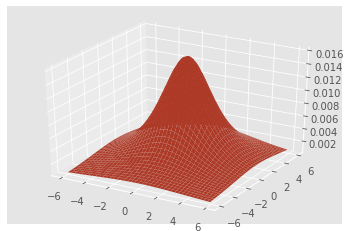

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z);

In [5]:
from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import LCG

In [6]:
gen = BasicRand(LCG())

In [7]:
n = 100000

In [8]:
xi1 = np.array([gen.next() for _ in range(n)])
xi2 = np.array([gen.next() for _ in range(n)])

y = 1 + math.pi * np.tan(math.pi * xi1 - math.pi / 2)
a = np.sqrt(math.pi**2 + (y - 1)**2)
x = a * np.abs(2 * xi2 - 1 / a) / np.sqrt(np.abs(1 - (2 * xi2 - 1 / a)**2)) 

In [9]:
y = np.array(list(y) + list(y))
x = np.array(list(x) + list(-x))

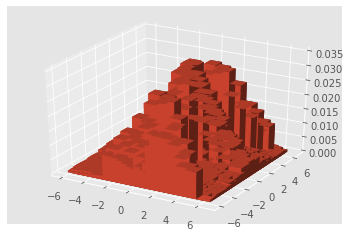

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[-6, 6], [-6, 6]], density=True)

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

plt.show()

(array([[ 4.,  1.,  1., ...,  8.,  4.,  2.],
        [ 2.,  6.,  3., ...,  7., 10.,  3.],
        [ 3.,  4.,  4., ...,  6.,  9.,  5.],
        ...,
        [ 3.,  4.,  4., ...,  6.,  9.,  5.],
        [ 2.,  6.,  3., ...,  7., 10.,  3.],
        [ 4.,  1.,  1., ...,  8.,  4.,  2.]]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92,  2.16,  2.4 ,
         2.64,  2.88,  3.12,  3.36,  3.6 ,  3.84,  4.08,  4.32,  4.56,
         4.8 ,  5.04,  5.28,  5.52,  5.76,  6.  ]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92,  2.16,  2.4 ,
         2.64,  2.88,  3

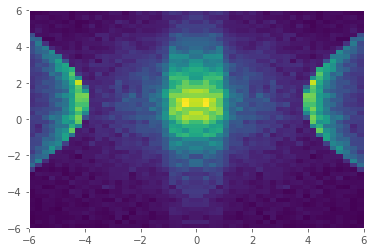

In [42]:
plt.hist2d(x, y, bins=(50, 50), range=[(-6, 6), (-6, 6)])

ValueError: too many values to unpack (expected 2)

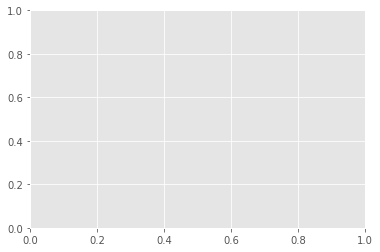

In [43]:
plt.hist2d(X, Y, bins=(50, 50), range=[(-6, 6), (-6, 6)])